In [3]:
import time
from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import interpolate
from sklearn.cluster import DBSCAN
import numpy as np

TGA/220801_CRM-1_PX_vapor.txt
7.076482  mg


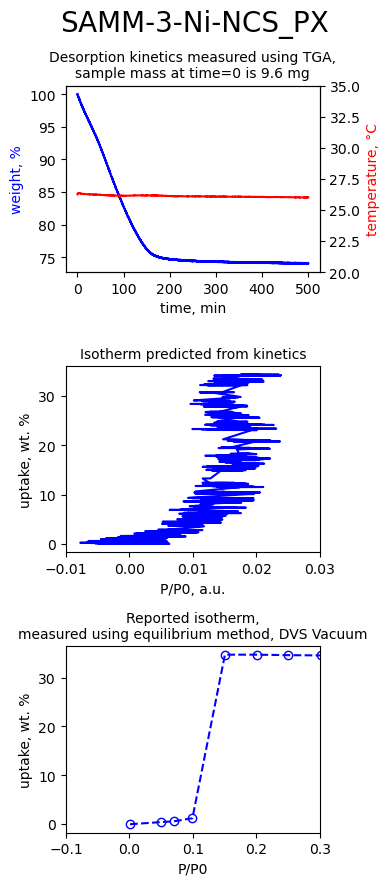

TGA/220802_CRM-1_EB_vapor.txt
8.078155  mg


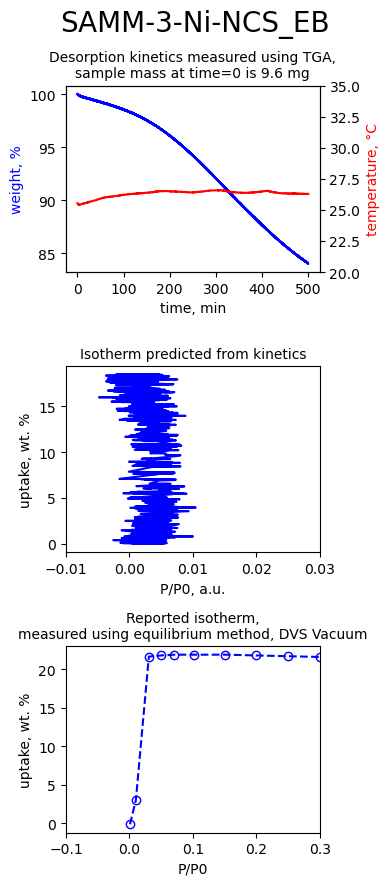

TGA/220909_CRM-2_OX_vapour.txt
5.094003  mg


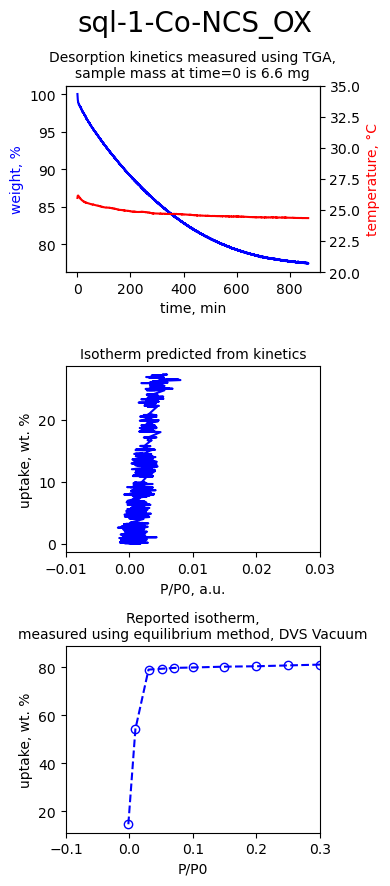

TGA/220910_CRM-2_MX_vapour.txt
4.380453  mg


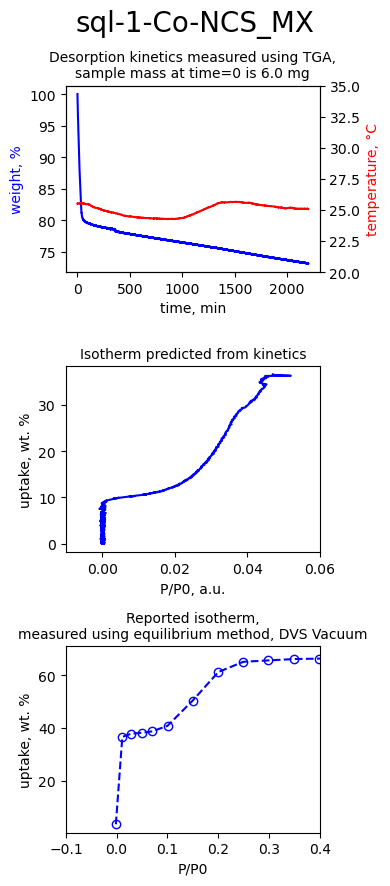

In [4]:
##################################################
####### main 
##################################################
filelist =  {'SAMM-3-Ni-NCS_PX':{'kinetics':'TGA/220801_CRM-1_PX_vapor.txt',
                        'isotherm':'literature/SAMM-3-Ni-NCS_PX_des.csv',
                       'PP0':[[-0.01, 0.03], [-0.1, 0.3]],
                       },
             'SAMM-3-Ni-NCS_EB':{'kinetics':'TGA/220802_CRM-1_EB_vapor.txt',
                        'isotherm':'literature/SAMM-3-Ni-NCS_EB_des.csv',
                        'PP0':[[-0.01, 0.03], [-0.1, 0.3]],
                        },
             'sql-1-Co-NCS_OX':{'kinetics':'TGA/220909_CRM-2_OX_vapour.txt',
                        'isotherm':'literature/sql-1-Co-NCS_OX_des.csv',
                        'PP0':[[-0.01, 0.03], [-0.1, 0.3]],
                        },
             'sql-1-Co-NCS_MX':{'kinetics':'TGA/220910_CRM-2_MX_vapour.txt',
                        'isotherm':'literature/sql-1-Co-NCS_MX_des.csv',
                        'PP0':[[-0.01, 0.06], [-0.1, 0.4]],
                        },
            }

text_size = 10
window1 = 50
window2 = 50
path = '../../../../data/C8_sorption/'
for material_name in filelist.keys():
    df = pd.read_csv(path+filelist[material_name]['kinetics'], skiprows=42, sep='\t', names = ['time', 'temp', 'mass'], encoding='iso-8859-1')
    print(filelist[material_name]['kinetics'])
    print(df.iloc[-1,2], ' mg')
    
    fig, ax = plt.subplots(3, 1, figsize=(4, 9))
    fig.suptitle(material_name, fontsize=text_size*2)
    
    # uptake desorption
    try:
        w_ads = pd.DataFrame({'time':df.time, 
                              'uptake':df.mass,
                              'temp':df.temp
                              })
    except Exception as e:
        print(e)
        continue
    ax[0].plot(w_ads['time'],
                  w_ads['uptake']/w_ads['uptake'].max()*100,
                   c='b'
                  )

    ax[0].set_xlabel('time, min', fontsize=text_size)
    ax[0].set_ylabel('weight, %', fontsize=text_size, c='b')
    ax[0].tick_params(axis='x', labelsize=text_size)
    ax[0].tick_params(axis='y', labelsize=text_size)
    ax[0].set_title('Desorption kinetics measured using TGA,\nsample mass at time=0 is {0} mg'.format(round(df.mass[0], 1)), 
                                                                                                      fontsize=text_size)
    ax_t = ax[0].twinx()
    ax_t.plot(w_ads['time'],
                  w_ads['temp'],
                  c='r',
             )
    ax_t.set_ylim([20, 35])
    ax_t.set_ylabel('temperature, °C', fontsize=text_size, c='r')
    ax_t.tick_params(axis='y', labelsize=text_size)
    
    # first derivative adsorption
    first_derivative_dwdt_ads = pd.DataFrame({'dwdt':(w_ads['uptake'].diff()/w_ads['time'].diff()).rolling(window=window1, min_periods=1).mean(),
                                              'uptake':w_ads['uptake']
                                              })

    # first derivative adsorption where second derivative is negatinve
    first_derivative_dwdt_dw_ads = pd.DataFrame({'dwdt_dw':(first_derivative_dwdt_ads['dwdt'].diff()/first_derivative_dwdt_ads['uptake'].diff()).rolling(window=window2, min_periods=1).mean(),
                                                 'uptake':first_derivative_dwdt_ads['uptake']
                                                 })
    def normalize(x):
        return (x-x.min())/(x.max()-x.min())
    X = np.array([[i[0], i[1]] for i in zip(normalize(first_derivative_dwdt_ads[first_derivative_dwdt_dw_ads['dwdt_dw']<0]['uptake']), normalize(first_derivative_dwdt_ads[first_derivative_dwdt_dw_ads['dwdt_dw']<0]['dwdt']))  ])
    clustering_ads = DBSCAN(eps=0.2, min_samples=1).fit(X)

    ### perform fitting/plot prediction
    try:       
        first_derivative_dwdt_ads['dwdt_scaled'] = first_derivative_dwdt_ads['dwdt']
        frames = [first_derivative_dwdt_ads[first_derivative_dwdt_dw_ads['dwdt_dw']<0][clustering_ads.labels_==np.bincount(clustering_ads.labels_).argmax()][['uptake', 'dwdt_scaled']],
                 ]
        joined_first_derivative_dwdt = pd.concat(frames, sort=True)
        joined_first_derivative_dwdt = joined_first_derivative_dwdt.sort_values(by=['uptake'])
        #ax[0, 2].plot(joined_first_derivative_dwdt['uptake'], joined_first_derivative_dwdt['dwdt'])   
        ax[1].plot(-joined_first_derivative_dwdt['dwdt_scaled'], 
                    100*(joined_first_derivative_dwdt['uptake']-joined_first_derivative_dwdt['uptake'].min())/joined_first_derivative_dwdt['uptake'].min(),
                     c='b',
                     )
        ax[1].set_xlabel('P/P0, a.u.', fontsize=text_size)
        ax[1].set_ylabel('uptake, wt. %', fontsize=text_size)
        ax[1].tick_params(axis='x', labelsize=text_size)
        ax[1].tick_params(axis='y', labelsize=text_size)
        ax[1].set_xlim([-joined_first_derivative_dwdt['dwdt_scaled'].max(), 
                        -joined_first_derivative_dwdt['dwdt_scaled'].min()])
        ax[1].set_xlim(filelist[material_name]['PP0'][0])
        ax[1].set_title('Isotherm predicted from kinetics', fontsize=text_size)
    except Exception as e: 
        print(e)
        pass
    
    # plot experimental isotherm
    try:
        df_lit = pd.read_csv(path+filelist[material_name]['isotherm'], names = ['PP0', 'uptake'])

        exp_isotherm_des = pd.DataFrame({'PP0_des':df_lit.PP0, 
                                 'des':df_lit.uptake
                                })
        PP0_max=filelist[material_name]['PP0']
        ax[2].plot(exp_isotherm_des.PP0_des, 
                   exp_isotherm_des.des,
                   linestyle='dashed',
                   c='b'
                  )
        ax[2].scatter(exp_isotherm_des.PP0_des, 
                      exp_isotherm_des.des,
                      facecolors='w', edgecolor='b',
                     )
        ax[2].set_ylabel('uptake, wt. %', fontsize=text_size)
        ax[2].set_xlabel('P/P0', fontsize=text_size)
        ax[2].tick_params(axis='x', labelsize=text_size)
        ax[2].tick_params(axis='y', labelsize=text_size)
        ax[2].set_xlim(filelist[material_name]['PP0'][1])
        ax[2].set_title('Reported isotherm,\nmeasured using equilibrium method, DVS Vacuum', fontsize=text_size)

    except Exception as e: 
        print(e)
        pass
    
    plt.tight_layout()
    plt.savefig(material_name+'_fromTGA.png', dpi=300)
    plt.show()
